In [54]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# HTML parsing
from bs4 import BeautifulSoup

# Text preprocessing
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

# Emoji handling
import emoji

# Tokenization and sequence padding for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

# Machine learning models and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax

# Data splitting for training and testing
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
from IPython.display import display
from collections import Counter
from wordcloud import WordCloud
import scipy.stats as st
from keras.callbacks import EarlyStopping  # Make sure to include this import
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import string
import nltk
from sklearn.metrics import classification_report
import scipy.stats as st

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import scipy.stats as st
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import scipy.stats as st
# ... any other imports you need ...


In [56]:
class SentimentAnalysisModel:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.df = None
        self.tokenizer = None
        self.maxlen = None
        self.model = None
        self.X_train_padded = None
        self.X_test_padded = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.dataset_path)
            self.df.rename(columns={'message to examine': 'Text', 'label (depression result)': 'Label'}, inplace=True)
            print("Data loaded successfully. Shape:", self.df.shape)
        except FileNotFoundError:
            print(f"File not found: {self.dataset_path}")
        except pd.errors.EmptyDataError:
            print("File is empty.")
        except pd.errors.ParserError:
            print("Error parsing file.")
        except Exception as e:
            print(f"An error occurred: {e}")


    def perform_eda(self):
        print("Dataset shape:", self.df.shape)
        print("Label distribution:\n", self.df['Label'].value_counts())
        sns.countplot(x='Label', data=self.df)
        plt.title('Label Distribution')
        plt.show()
        
        self.df['Text_Length'] = self.df['Text'].apply(len)
        sns.histplot(data=self.df, x='Text_Length', bins=30, kde=True)
        plt.title('Text Length Distribution')
        plt.show()
        

    
    def preprocess_text(self):
        self.df['Text'] = self.df['Text'].str.lower()
        self.df['Text'] = self.df['Text'].apply(self.remove_html_tags)
        self.df['Text'] = self.df['Text'].apply(self.remove_urls)
        self.df['Text'] = self.df['Text'].apply(self.remove_punctuation)
        self.df['Text'] = self.df['Text'].apply(self.replace_chat_words)
        self.df['Text'] = self.df['Text'].apply(self.remove_stopwords)
        self.df['Text'] = self.df['Text'].apply(self.remove_emojis)
        self.df['Text'] = self.df['Text'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word , pos='v') for word in x.split()]))
    def visualize_word_frequency(self):
        all_words = ' '.join(self.df['Text']).split()
        most_common_words = Counter(all_words).most_common(50)
        
        plt.figure(figsize=(15, 10))
        sns.barplot(x=[word[1] for word in most_common_words], y=[word[0] for word in most_common_words])
        plt.title('Top 50 Most Common Words in Dataset')
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.show()

    def show_data_after_cleaning(self):
        # Display a portion of the dataframe after preprocessing
        print("Data after cleaning:")
        display(self.df.head())
    @staticmethod
    def remove_html_tags(text):
        soup = BeautifulSoup(text, 'html.parser')
        return soup.get_text()
    
    @staticmethod
    def remove_urls(text):
        return re.sub(r'http\S+|www\S+', '', text)
    
    @staticmethod
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def replace_chat_words(self, text):
        chat_words_str = """
        # Your chat words mappings go here
        """
        chat_words_map_dict = {}
        chat_words_list = chat_words_str.strip().split('\n')
        for chat_word in chat_words_list:
            if ':' in chat_word:  # Check if the line contains a colon
                word, definition = chat_word.split(":", 1)
                chat_words_map_dict[word.strip()] = definition.strip()
        words = text.split()
        for i, word in enumerate(words):
            if word.upper() in chat_words_map_dict:
                words[i] = chat_words_map_dict[word.upper()]
        return ' '.join(words)

    
    def remove_stopwords(self, text):
        stop_words = set(stopwords.words('english'))
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    @staticmethod
    def remove_emojis(text):
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"  # flags (iOS)
                                "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)


    def prepare_data(self):
        X = self.df['Text']
        y = self.df['Label']
        X_train, X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.tokenizer = Tokenizer(oov_token='nothing')
        self.tokenizer.fit_on_texts(X_train)
        X_train_sequences = self.tokenizer.texts_to_sequences(X_train)
        X_test_sequences = self.tokenizer.texts_to_sequences(X_test)
        self.maxlen = max(len(x) for x in X_train_sequences)
        self.X_train_padded = pad_sequences(X_train_sequences, maxlen=self.maxlen, padding='post')
        self.X_test_padded = pad_sequences(X_test_sequences, maxlen=self.maxlen, padding='post')

    def define_model(self):
        self.model = Sequential()
        self.model.add(LSTM(128, input_shape=(self.maxlen,1), return_sequences=True))
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(128))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    def train_model(self):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
        self.history = self.model.fit(
            self.X_train_padded, 
            self.y_train, 
            epochs=10, 
            batch_size=64, 
            validation_data=(self.X_test_padded, self.y_test),
            callbacks=[early_stopping]
        )
        self.plot_history(self.history)
        evaluation = self.model.evaluate(self.X_test_padded, self.y_test, verbose=0)
        print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

    def evaluate_model(self):
        predictions = (self.model.predict(self.X_test_padded) > 0.5).astype(int)
        print(classification_report(self.y_test, predictions, target_names=['Non-Depressed', 'Depressed']))

        # Calculate the confidence interval for the test accuracy
        test_accuracy = np.array(self.history.history['val_accuracy'])
        confidence_interval = st.t.interval(0.95, len(test_accuracy)-1, loc=np.mean(test_accuracy), scale=st.sem(test_accuracy))
        print(f"95% confidence interval for the test accuracy: {confidence_interval}")

    def plot_confusion_matrix(self):
        predictions = (self.model.predict(self.X_test_padded) > 0.5).astype(int)
        cm = confusion_matrix(self.y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def generate_wordcloud(self):
        text = ' '.join(self.df['Text'])
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Cleaned Text')
        plt.show()

    @staticmethod
    def plot_history(history):
        # Plot accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()


In [57]:
model = SentimentAnalysisModel('sentiment_tweets3.csv')

In [58]:
model.load_data()

Data loaded successfully. Shape: (10314, 3)


Dataset shape: (10314, 3)
Label distribution:
 Label
0    8000
1    2314
Name: count, dtype: int64


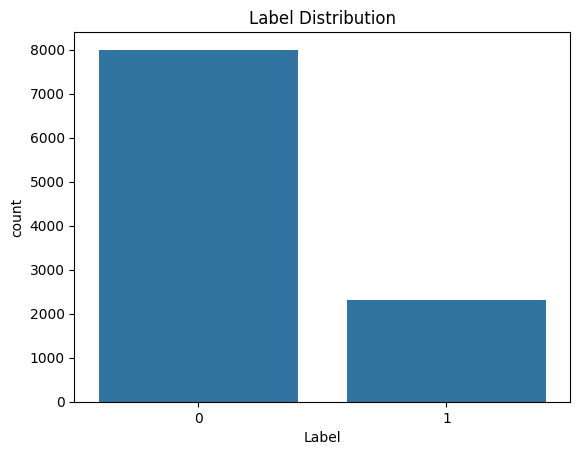

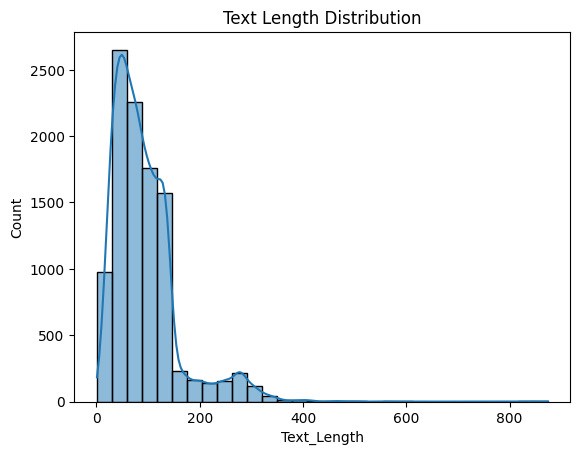

In [59]:
model.perform_eda()

In [60]:
model.preprocess_text()

In [61]:
model.show_data_after_cleaning()

Data after cleaning:


,Index,Text,Label,Text_Length
0,106,real good moment miss much,0,57
1,217,read manga,0,42
2,220,comeagainjen,0,84
3,288,lapcat need send em accountant tomorrow oddly ...,0,135
4,540,add myspace myspacecomlookthunder,0,45


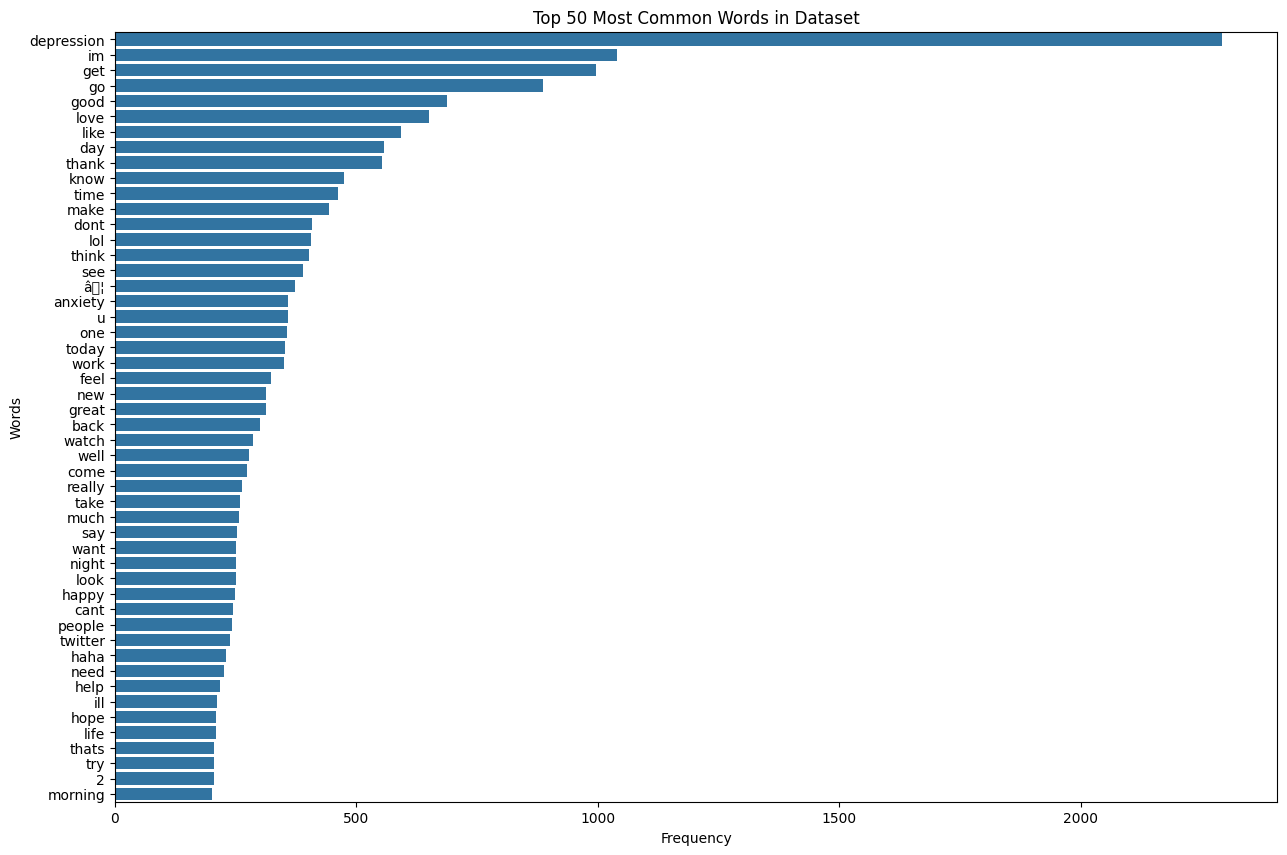

In [62]:
model.visualize_word_frequency()

In [63]:
model.prepare_data()

In [64]:
model.define_model()

Epoch 1/10
129/129 [==============================] - 21s 140ms/step - loss: 0.4806 - accuracy: 0.8121 - val_loss: 0.4400 - val_accuracy: 0.8279
Epoch 2/10
129/129 [==============================] - 18s 137ms/step - loss: 0.4482 - accuracy: 0.8244 - val_loss: 0.4329 - val_accuracy: 0.8323
Epoch 3/10
129/129 [==============================] - 17s 135ms/step - loss: 0.4598 - accuracy: 0.8201 - val_loss: 0.4446 - val_accuracy: 0.8289
Epoch 4/10
129/129 [==============================] - 18s 142ms/step - loss: 0.4281 - accuracy: 0.8297 - val_loss: 0.3160 - val_accuracy: 0.8672
Epoch 5/10
129/129 [==============================] - 18s 136ms/step - loss: 0.5167 - accuracy: 0.7872 - val_loss: 0.4957 - val_accuracy: 0.7824
Epoch 6/10
129/129 [==============================] - 18s 139ms/step - loss: 0.4909 - accuracy: 0.8004 - val_loss: 0.4425 - val_accuracy: 0.8270
Epoch 7/10
129/129 [==============================] - 18s 140ms/step - loss: 0.4586 - accuracy: 0.8263 - val_loss: 0.4510 - val_ac

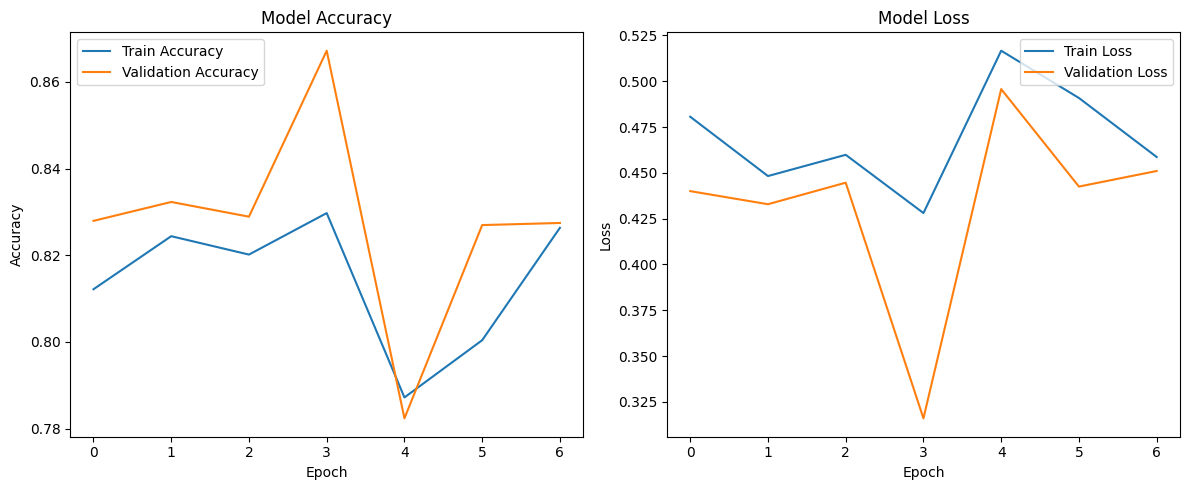

Test Loss: 0.4510079324245453, Test Accuracy: 0.8274357914924622


In [65]:
model.train_model()  

In [66]:
model.evaluate_model()

               precision    recall  f1-score   support

Non-Depressed       0.84      0.96      0.90      1614
    Depressed       0.70      0.36      0.47       449

     accuracy                           0.83      2063
    macro avg       0.77      0.66      0.69      2063
 weighted avg       0.81      0.83      0.80      2063

95% confidence interval for the test accuracy: (0.8048008589674984, 0.850347664226951)


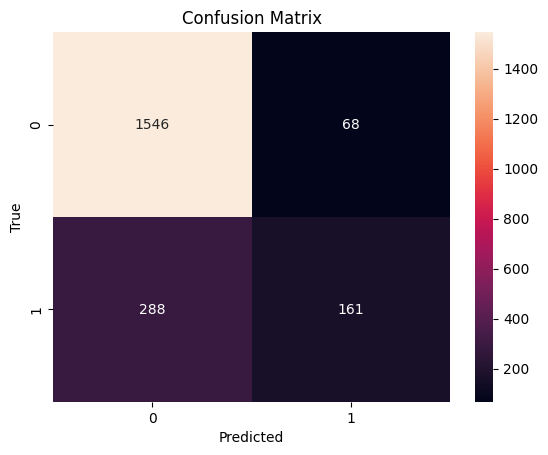

In [67]:
model.plot_confusion_matrix()

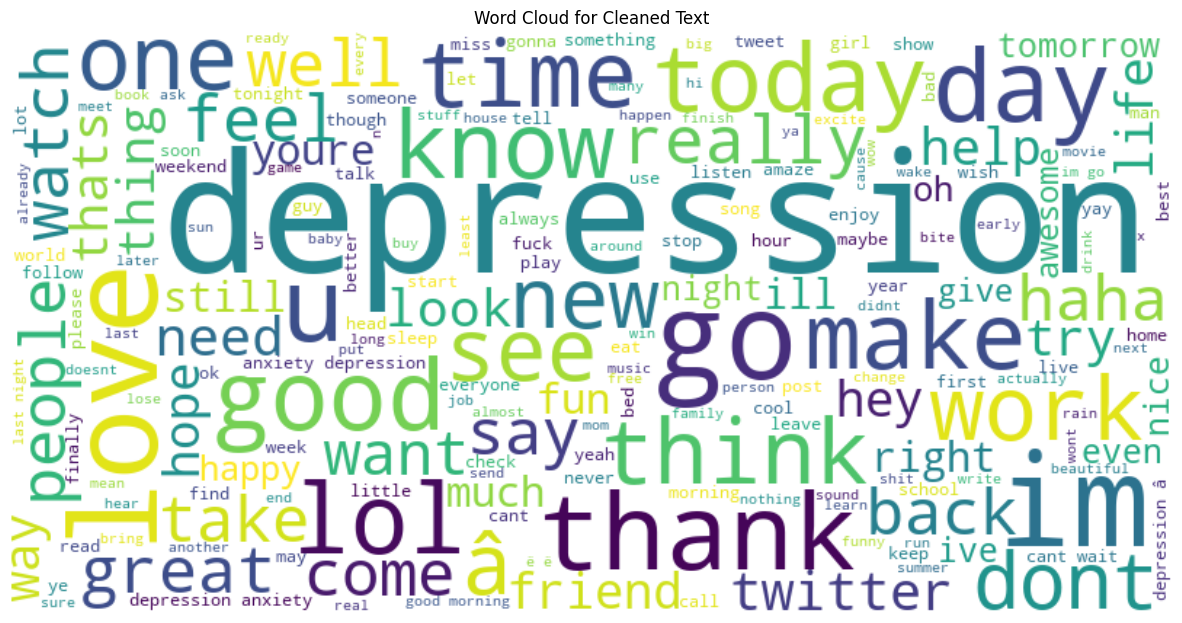

In [68]:
model.generate_wordcloud()